### Load libraries

In [1]:
library(xgboost)
library(data.table)
library(Metrics)

### Load data (train & test)

In [61]:
train = fread("../input/train.csv", showProgress = TRUE)
test = fread("../input/test.csv", showProgress = TRUE)

y_train = train$loss
train[, c("id", "loss") := NULL]
test[, c("id") := NULL]

### One hot encoding

In [62]:
ntrain = nrow(train)
df_all = rbind(train, test)

In [63]:
features = names(train)

for (f in features) {
  if (class(df_all[[f]])=="character") {
    levels <- sort(unique(df_all[[f]]))
    df_all[[f]] <- as.integer(factor(df_all[[f]], levels=levels))
  }
}

### Prepare dataset

In [64]:
df_train = df_all[1:ntrain,]
df_test = df_all[(ntrain+1):nrow(df_all),]

dtrain = xgb.DMatrix(as.matrix(df_train), label=y_train)
dtest = xgb.DMatrix(as.matrix(df_test))

### save or load data matrix

In [65]:
system.time( xgb.DMatrix(as.matrix(df_train), label=y_train) )

xgb.DMatrix.save(dtrain, '../input/dtrain.dat')
system.time( xgb.DMatrix('../input/dtrain.dat') )

   user  system elapsed 
  0.499   0.290   0.795 

[1] TRUE

[01:10:27] 188318x130 matrix with 24481340 entries loaded from ../input/dtrain.dat


   user  system elapsed 
   0.00    0.12    0.12 

### train model

In [73]:
set.seed(2017)

xgb_params = list(
  seed = 0,
  colsample_bytree = 0.7,
  subsample = 0.7,
  eta = 0.3,
  objective = 'reg:linear',
  max_depth = 6
)

model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=30, 
    maximize = F)

## save and load model

In [54]:
xgb.save(model, '../models/xgb.dat')
model1 = xgb.load('../models/xgb.dat')

[1] TRUE

## Advanced features
1. Customization of objective & eval metrics
2. "Continous" training
3. Embeded feature importance estimator
4. Early-stopping

### Customization eval metrics

In [58]:
xg_eval_mae <- function (y_pred, dtrain) {
   y = getinfo(dtrain, "label")
   err= mae(y, y_pred)
   return (list(metric = "error", value = err))
}


### Customization of objective

In [57]:
logcoshobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  grad <- tanh(preds-labels)
  hess <- 1-grad*grad
  return(list(grad = grad, hess = hess))
}

cauchyobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  c <- 3  #the lower the "slower/smoother" the loss is. Cross-Validate.
  x <-  preds-labels
  grad <- x / (x^2/c^2+1)
  hess <- -c^2*(x^2-c^2)/(x^2+c^2)^2
  return(list(grad = grad, hess = hess))
}


fairobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  c <- 2 #the lower the "slower/smoother" the loss is. Cross-Validate.
  x <-  preds-labels
  grad <- c*x / (abs(x)+c)
  hess <- c^2 / (abs(x)+c)^2
  return(list(grad = grad, hess = hess))
}

In [71]:
xgb_params = list(
  seed = 0,
  colsample_bytree = 0.7,
  subsample = 0.7,
  eta = 0.3,
  objective = logcoshobj,    # <<<<=== custom objective
  eval_metric = xg_eval_mae, # <<<<=== custom eval mae
  max_depth = 6
)

model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=30, 
    maximize = F)

## "Continous" training

In [82]:
model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=2, 
    maximize = F)

ptrain = predict(model, dtrain, outputmargin=TRUE)
setinfo(dtrain, "base_margin", ptrain)

model = xgb.train(
    xgb_params, 
    dtrain, 
    nrounds=2, 
    maximize = F)


[1] 1521.347 1633.681 3780.010 1129.133 5233.508 4023.927

## feature importance estimator

In [74]:
importance <- xgb.importance(feature_names = names(df_all), model = model)
head(importance, 20)

Feature,Gain,Cover,Frequency
cat80,0.394974865,0.046200336,0.026239067
cat79,0.111117112,0.037072685,0.045481050
cat57,0.101533560,0.031853809,0.019825073
cat12,0.050105091,0.024825435,0.016909621
cat81,0.035151914,0.024119877,0.032653061
cat75,0.020450466,0.032156985,0.026239067
cat86,0.017664755,0.055703493,0.054227405
cat1,0.015675463,0.025936957,0.016909621
cat71,0.015194348,0.029340269,0.030320700
cat72,0.014815307,0.016270858,0.023323615


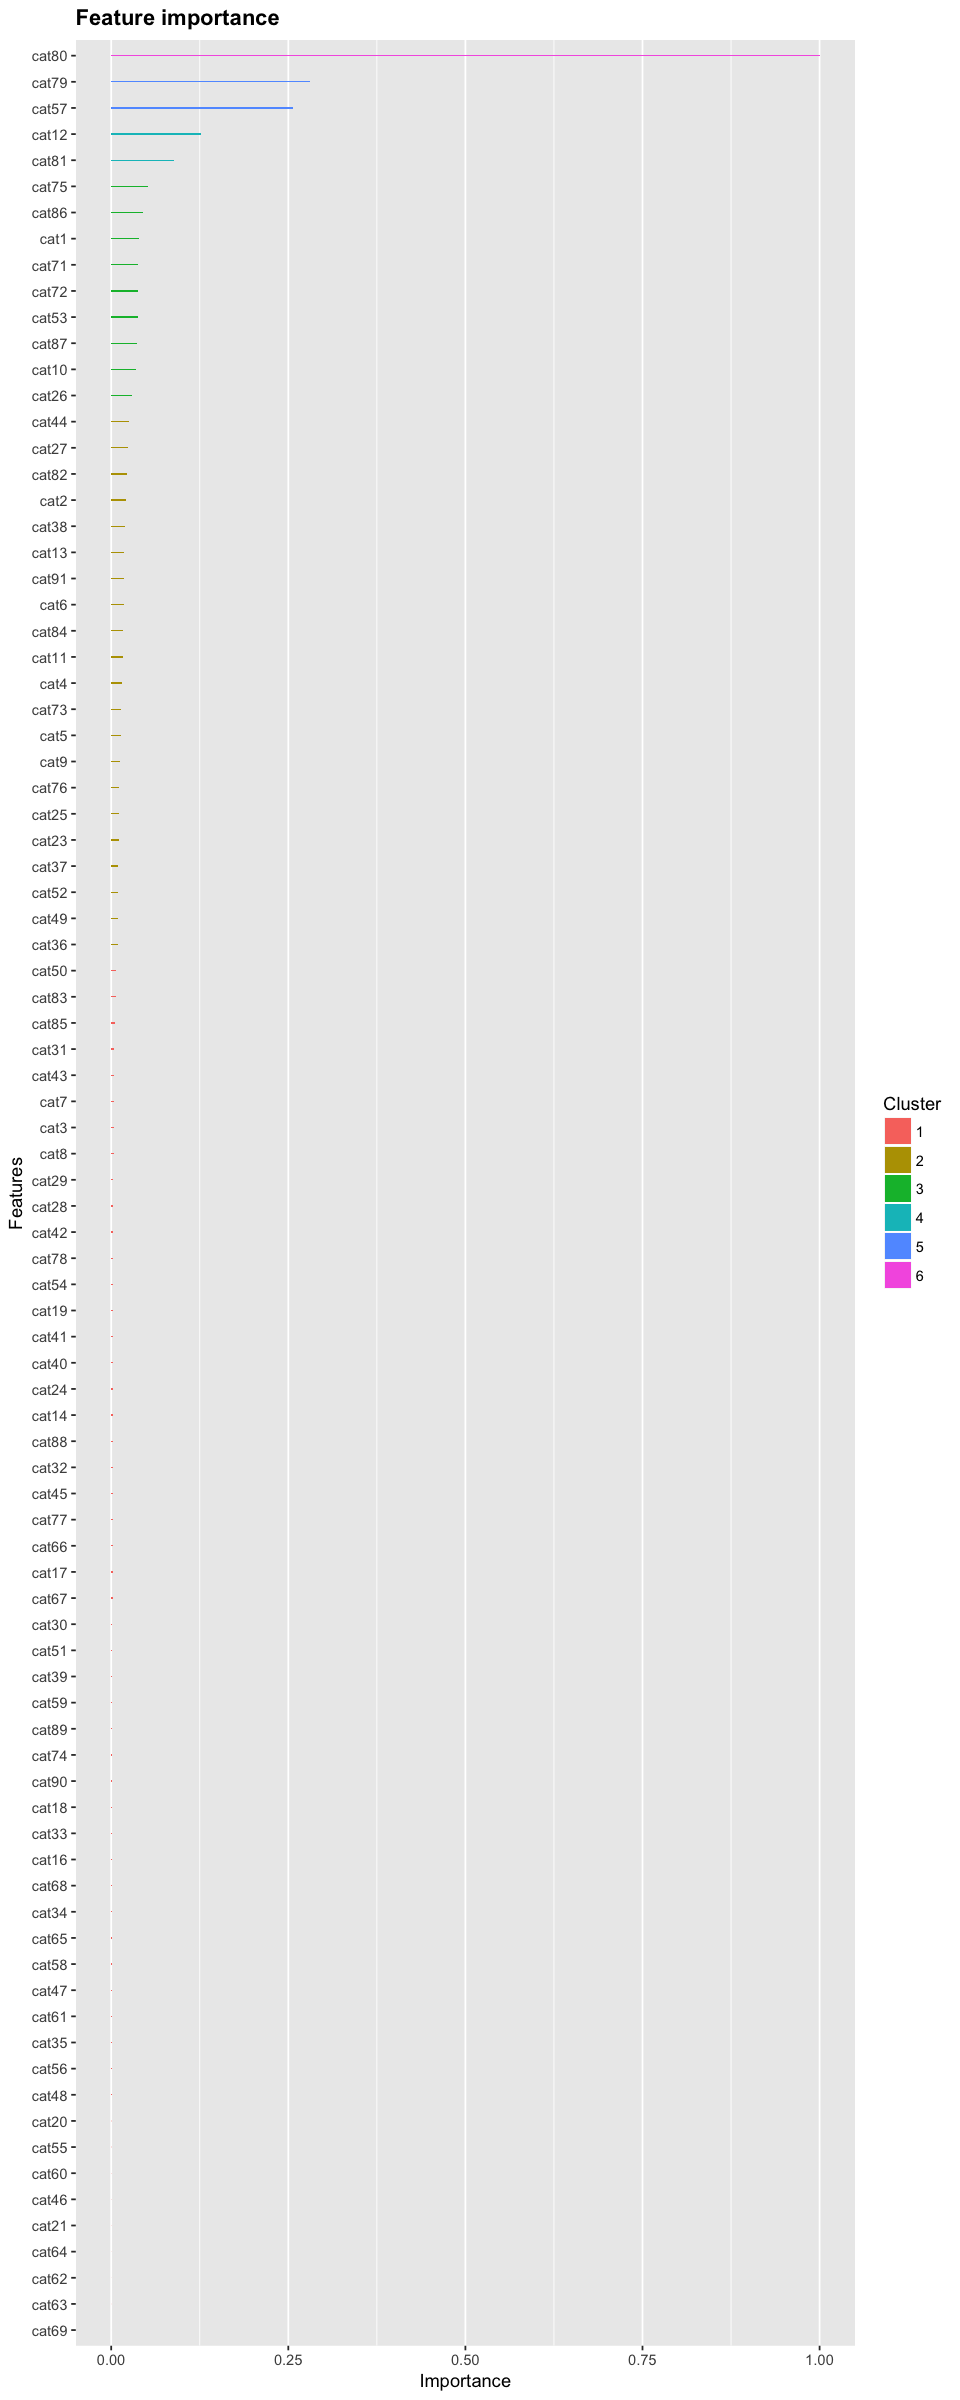

In [75]:
#install.packages("ggplot2")
#install.packages("Ckmeans.1d.dp")
#install.packages("vcd")

library(ggplot2)

importance_matrix <- xgb.importance(names(train), model = model)

#xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Relative importance")

options(repr.plot.width=8, repr.plot.height=20)
(gg <- xgb.ggplot.importance(importance_matrix, measure = "Gain", rel_to_first = TRUE)) #Frequince, Cover


## Questoins:
1. what does mean feature importance?
2. what the difference between in FI between: Gain, Cover, Frequences?

## Links
1. 

In [86]:
xgb.save(model, '../models/xgb.dat')